교차 검증 0 정확도: 0.9593
교차 검증 1 정확도: 0.9647
교차 검증 2 정확도: 0.9575
교차 검증 3 정확도: 0.9322
교차 검증 4 정확도: 0.9408
평균 정확도: 0.9509
훈련 정확도: 0.9665
테스트 정확도: 0.9620
훈련 분류 보고서:
              precision    recall  f1-score   support

          -1       0.98      0.95      0.96      3942
           1       0.96      0.98      0.97      4902

    accuracy                           0.97      8844
   macro avg       0.97      0.96      0.97      8844
weighted avg       0.97      0.97      0.97      8844

테스트 분류 보고서:
              precision    recall  f1-score   support

          -1       0.97      0.94      0.96       956
           1       0.96      0.98      0.97      1255

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


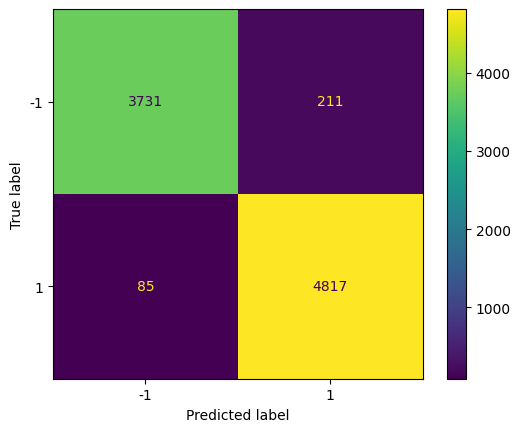

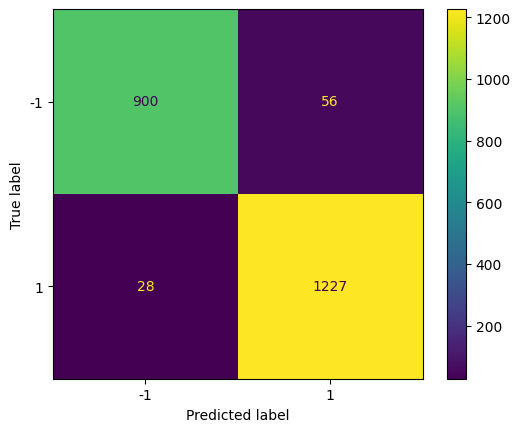

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 및 준비
df = pd.read_csv('dataset.csv')
df = df.iloc[:, 1:]

# 특정 피처 드랍
df = df.drop(columns=['web_traffic'])
df = df.drop(columns=['Page_Rank'])
df = df.drop(columns=['Links_pointing_to_page'])
df = df.drop(columns=['Statistical_report'])

df = df.drop(columns=['Shortining_Service'])

df = df.drop(columns=['RightClick'])
df = df.drop(columns=['on_mouseover'])
df = df.drop(columns=['Iframe'])
df = df.drop(columns=['Favicon'])

X = df.drop(columns=['Result'])
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MLP 모델 인스턴스화
mlp = MLPClassifier(max_iter=1000, learning_rate_init=0.005, random_state=42)

# # 최적의 파라미터를 사용하여 MLPClassifier 모델을 초기화
# mlp = MLPClassifier(
#     alpha = 0.001,
#     hidden_layer_sizes = (100, 50),
#     learning_rate_init = 0.01,
#     random_state=42
# )

# 모델 학습
mlp.fit(X_train, y_train)

# 교차 검증 수행
def exec_kfold(clf, folds=5):
    kfold = KFold(n_splits=folds)
    scores = []

    for iter_count, (train_index, test_index) in enumerate(kfold.split(X)):
        X_train_kf, X_test_kf = X.values[train_index], X.values[test_index]
        y_train_kf, y_test_kf = y.values[train_index], y.values[test_index]

        clf.fit(X_train_kf, y_train_kf)
        predictions = clf.predict(X_test_kf)
        accuracy = accuracy_score(y_test_kf, predictions)
        scores.append(accuracy)
        print(f"교차 검증 {iter_count} 정확도: {accuracy:.4f}")

    mean_score = np.mean(scores)
    print(f"평균 정확도: {mean_score:.4f}")

exec_kfold(mlp, folds=5)

# 모델 평가
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_report = classification_report(y_train, y_train_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'훈련 정확도: {train_accuracy:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')
print('훈련 분류 보고서:')
print(train_report)
print('테스트 분류 보고서:')
print(test_report)

# 혼동 행렬
cm_train = confusion_matrix(y_train, y_train_pred, labels=mlp.classes_)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=mlp.classes_)
disp_train.plot()
plt.show()

cm_test = confusion_matrix(y_test, y_test_pred, labels=mlp.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=mlp.classes_)
disp_test.plot()
plt.show()



In [5]:
# 하이퍼파라미터 튜닝
parameters = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'learning_rate_init': [0.001, 0.005, 0.01],
    'alpha': [0.0001, 0.001, 0.01],
}

grid_mlp = GridSearchCV(mlp, param_grid=parameters, scoring='accuracy', n_jobs=-1, cv=5)
grid_mlp.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :', grid_mlp.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_mlp.best_score_))

# 최적 모델 평가
best_mlp = grid_mlp.best_estimator_
dpredictions = best_mlp.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 최적 MLP 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01}
GridSearchCV 최고 정확도: 0.9555
테스트 세트에서의 최적 MLP 정확도 : 0.9548


In [7]:
# 모델을 pkl 파일로 저장
import pickle

try:
    with open('mlp_model_column_drop.pkl', 'wb') as f:
        pickle.dump(mlp, f)
    print("모델이 성공적으로 저장되었습니다.")
except Exception as e:
    print(f"모델 저장 중 오류 발생: {e}")

모델이 성공적으로 저장되었습니다.
